## Predictive Neural Network
In this project, we'll build a pure python Neural Network and given the following information, the task is to predict the demand for the next 10 weeks (Weeks: 146-155) for the center-meal combinations in the test set:  

- Historical data of demand for a product-center combination (Weeks: 1 to 145)
- Product(Meal) features such as category, sub-category, current price and discount
- Information for fulfillment center like center area, city information etc.

## Food Demand Forecasting Data
The data has been fetched from https://datahack.analyticsvidhya.com/contest/genpact-machine-learning-hackathon-1/

## Evaluation Metric
The evaluation metric for this competition is 100*RMSLE where RMSLE is Root of Mean Squared Logarithmic Error across all entries in the test set.

## Data Dictionary
 
#### Weekly Demand data (train.csv): 

Contains the historical demand data for all centers, test.csv contains all the following features except the target variable
 

| Variable              | Definition                                               |
|-----------------------|----------------------------------------------------------|
| id                    | Unique ID                                                |
| week                  | Week No                                                  |
| center_id             | Unique ID for fulfillment center                         |
| meal_id               | Unique ID for Meal                                       |
| checkout_price        | Final price including discount, taxes & delivery charges |
| base_price            | Base price of the meal                                   |
| emailer_for_promotion | Emailer sent for promotion of meal                       |
| homepage_featured     | Meal featured at homepage                                |
| num_orders            | (Target) Orders Count  
   

#### fulfilment_center_info.csv: 
Contains information for each fulfilment center
 

| Variable    | Definition                       |
|-------------|----------------------------------|
| center_id   | Unique ID for fulfillment center |
| city_code   | Unique code for city             |
| region_code | Unique code for region           |
| center_type | Anonymized center type           |
| op_area     | Area of operation (in km^2)      |
 

#### meal_info.csv: 
Contains information for each meal being served
 

| Variable | Definition                              |
|----------|-----------------------------------------|
| meal_id  | Unique ID for the meal                  |
| category | Type of meal (beverages/snacks/soups….) |
| cuisine  | Meal cuisine (Indian/Italian/…)         |

## Import packages

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

## Load and prepare the data

In [2]:
%%time
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
fulfilment_center = pd.read_csv('datasets/fulfilment_center_info.csv')
meal_info = pd.read_csv('datasets/meal_info.csv')

Wall time: 499 ms


In [3]:
train.shape, fulfilment_center.shape, meal_info.shape, test.shape

((456548, 9), (77, 5), (51, 3), (32573, 8))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
id                       456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
num_orders               456548 non-null int64
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [5]:
fulfilment_center.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 5 columns):
center_id      77 non-null int64
city_code      77 non-null int64
region_code    77 non-null int64
center_type    77 non-null object
op_area        77 non-null float64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.1+ KB


In [6]:
meal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
meal_id     51 non-null int64
category    51 non-null object
cuisine     51 non-null object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
id                       32573 non-null int64
week                     32573 non-null int64
center_id                32573 non-null int64
meal_id                  32573 non-null int64
checkout_price           32573 non-null float64
base_price               32573 non-null float64
emailer_for_promotion    32573 non-null int64
homepage_featured        32573 non-null int64
dtypes: float64(2), int64(6)
memory usage: 2.0 MB


## Sample data

In [8]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [9]:
fulfilment_center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [10]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [11]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


## Merge provided datasets

In [12]:
%%time
train = pd.merge(train, fulfilment_center, how='left', on=['center_id'])
test = pd.merge(test, fulfilment_center, how='left', on=['center_id'])
train = pd.merge(train, meal_info, how='left', on=['meal_id'])
test = pd.merge(test, meal_info, how='left', on=['meal_id'])
train.shape,test.shape

Wall time: 322 ms


((456548, 15), (32573, 14))

In [13]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


## Feature Engineering

### Group train and test

In [14]:
train['train_or_test'] = 'train'
test['train_or_test'] = 'test'
total_data = train.append(test).reset_index(drop=True)[train.columns]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


### Sort and view data by combination of week, center_id and meal_id

In [15]:
total_data = total_data.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

In [16]:
total_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,train_or_test
0,1436842,1,10,1062,181.39,181.39,0,0,865.0,590,56,TYPE_B,6.3,Beverages,Italian,train
1,1205013,2,10,1062,183.36,182.36,0,0,782.0,590,56,TYPE_B,6.3,Beverages,Italian,train
2,1447751,3,10,1062,184.36,182.36,0,0,851.0,590,56,TYPE_B,6.3,Beverages,Italian,train
3,1014968,4,10,1062,182.36,183.36,0,0,1202.0,590,56,TYPE_B,6.3,Beverages,Italian,train
4,1003563,5,10,1062,183.39,181.39,0,0,958.0,590,56,TYPE_B,6.3,Beverages,Italian,train


### No of week in year

In [17]:
total_data['week_num'] = total_data.week%52

### Discount amount

In [18]:
total_data['discount_amount'] = total_data.base_price-train.checkout_price

In [19]:
total_data["discount_ratio"] = total_data["base_price"] / total_data["checkout_price"]

### Center count features

In [20]:
gdf = total_data.groupby(["center_id", "week"])["id"].agg(['size']).reset_index()
gdf.columns = ["center_id", "week", "center_week_count"]
total_data = pd.merge(total_data,gdf, on=["center_id", "week"], how="left")

gdf = total_data.groupby(["center_id", "category"])["id"].count().reset_index()
gdf.columns = ["center_id", "category", "center_cat_count"]
total_data = pd.merge(total_data,gdf, on=["center_id", "category"], how="left")

gdf = total_data.groupby(["center_id", "category", "week"])["id"].count().reset_index()
gdf.columns = ["center_id", "category", "week", "center_cat_week_count"]
total_data = pd.merge(total_data,gdf, on=["center_id", "category", "week"], how="left")

gdf = total_data.groupby(["center_id", "cuisine"])["id"].count().reset_index()
gdf.columns = ["center_id", "cuisine", "center_cui_count"]
total_data = pd.merge(total_data,gdf, on=["center_id", "cuisine"], how="left")

### Meal count features

In [21]:
gdf = total_data.groupby(["meal_id"])["id"].count().reset_index()
gdf.columns = ["meal_id", "meal_count"]
total_data = pd.merge(total_data,gdf, on=["meal_id"], how="left")

gdf = total_data.groupby(["region_code", "meal_id"])["id"].count().reset_index()
gdf.columns = ["region_code", "meal_id", "region_meal_count"]
total_data= pd.merge(total_data,gdf, on=["region_code", "meal_id"], how="left")

gdf = total_data.groupby(["meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["meal_id", "week", "meal_week_count"]
total_data = pd.merge(total_data,gdf, on=["meal_id", "week"], how="left")

gdf =total_data.groupby(["center_type", "meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["center_type", "meal_id", "week", "type_meal_week_count"]
total_data = pd.merge(total_data,gdf, on=["center_type", "meal_id", "week"], how="left")

gdf = total_data.groupby(["region_code", "meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["region_code", "meal_id", "week", "region_meal_week_count"]
total_data = pd.merge(total_data,gdf, on=["region_code", "meal_id", "week"], how="left")

gdf =total_data.groupby(["city_code", "meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["city_code", "meal_id", "week", "city_meal_week_count"]
total_data = pd.merge(total_data,gdf, on=["city_code", "meal_id", "week"], how="left")

### View data

In [22]:
total_data = total_data.drop(['id', 'week', 'center_id', 'meal_id', 'region_code', 'city_code'], axis=1)

In [23]:
total_data.head()

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,center_type,op_area,category,cuisine,train_or_test,...,center_week_count,center_cat_count,center_cat_week_count,center_cui_count,meal_count,region_meal_count,meal_week_count,type_meal_week_count,region_meal_week_count,city_meal_week_count
0,181.39,181.39,0,0,865.0,TYPE_B,6.3,Beverages,Italian,train,...,45,1859,12,1791,11903,4644,77,15,30,9
1,183.36,182.36,0,0,782.0,TYPE_B,6.3,Beverages,Italian,train,...,45,1859,12,1791,11903,4644,77,15,30,9
2,184.36,182.36,0,0,851.0,TYPE_B,6.3,Beverages,Italian,train,...,45,1859,12,1791,11903,4644,77,15,30,9
3,182.36,183.36,0,0,1202.0,TYPE_B,6.3,Beverages,Italian,train,...,44,1859,12,1791,11903,4644,77,15,30,9
4,183.39,181.39,0,0,958.0,TYPE_B,6.3,Beverages,Italian,train,...,44,1859,12,1791,11903,4644,76,14,30,9


In [24]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 489121 entries, 0 to 489120
Data columns (total 23 columns):
checkout_price            489121 non-null float64
base_price                489121 non-null float64
emailer_for_promotion     489121 non-null int64
homepage_featured         489121 non-null int64
num_orders                456548 non-null float64
center_type               489121 non-null object
op_area                   489121 non-null float64
category                  489121 non-null object
cuisine                   489121 non-null object
train_or_test             489121 non-null object
week_num                  489121 non-null int64
discount_amount           456548 non-null float64
discount_ratio            489121 non-null float64
center_week_count         489121 non-null int64
center_cat_count          489121 non-null int64
center_cat_week_count     489121 non-null int64
center_cui_count          489121 non-null int64
meal_count                489121 non-null int64
region_me

In [25]:
total_data.describe()

,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,op_area,week_num,discount_amount,discount_ratio,center_week_count,center_cat_count,center_cat_week_count,center_cui_count,meal_count,region_meal_count,meal_week_count,type_meal_week_count,region_meal_week_count,city_meal_week_count
count,489121.000000,489121.000000,489121.000000,489121.000000,456548.000000,489121.000000,489121.000000,456548.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000,489121.000000
mean,332.879277,354.312259,0.080172,0.107346,261.872760,4.083865,25.840099,22.037559,1.081643,41.854733,797.192693,5.263992,1645.522088,10346.169052,3031.011727,68.059603,28.728354,20.008957,2.730566
std,153.022073,160.352168,0.271560,0.309552,395.922798,1.092163,14.903933,221.461819,0.242382,5.396825,618.424386,3.952742,302.569548,2083.444162,1283.435836,13.216269,13.190793,8.378235,2.692796
min,2.970000,55.350000,0.000000,0.000000,13.000000,0.900000,0.000000,-671.240000,0.578738,16.000000,1.000000,1.000000,778.000000,2718.000000,33.000000,1.000000,1.000000,1.000000,1.000000
25%,228.010000,243.500000,0.000000,0.000000,54.000000,3.600000,13.000000,-127.040000,0.998529,38.000000,414.000000,3.000000,1472.000000,10020.000000,2380.000000,65.000000,15.000000,17.000000,1.000000
50%,299.760000,311.430000,0.000000,0.000000,136.000000,4.000000,26.000000,16.460000,1.000187,42.000000,463.000000,3.000000,1647.000000,11175.000000,3178.000000,74.000000,31.000000,21.000000,1.000000
75%,445.230000,458.810000,0.000000,0.000000,324.000000,4.500000,39.000000,164.900000,1.026664,46.000000,1726.000000,11.000000,1762.000000,11861.000000,4167.000000,77.000000,43.000000,28.000000,3.000000
max,1113.620000,1112.620000,1.000000,1.000000,24299.000000,7.000000,51.000000,937.990000,106.481481,51.000000,1859.000000,12.000000,2303.000000,11908.000000,4649.000000,77.000000,43.000000,30.000000,9.000000


### Resplit data

In [26]:
train_data = total_data.loc[total_data['train_or_test']=='train', :]
test_data = total_data.loc[total_data['train_or_test']=='test', :]

In [28]:
for i in train_data.columns :
    if train_data[i].dtypes=='object':
        print(i)
        le=LabelEncoder()
        train_data[i]=le.fit_transform(train_data[i])
        test_data[i]=le.transform(test_data[i])

In [29]:
target_field = ['num_orders']
features, targets = train_data.drop(target_field, axis=1), train_data[target_field]

In [30]:
# Create validation set from train_data
train_features, train_targets = features.sample(frac=0.6,random_state=200), targets.sample(frac=0.6,random_state=200)
val_features, val_targets = features.drop(train_features.index), targets.drop(train_targets.index)

In [34]:
train_features.shape, val_features.shape, train_targets.shape, val_targets.shape

((273929, 22), (182619, 22), (273929, 1), (182619, 1))

## Model building

### Import python file for neural network functions

In [35]:
from SimpleNeuralNetwork import NeuralNetwork

### Define evaluation metric

In [36]:
import numpy as np

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_pred, y_test) : 
    assert len(y_test) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

In [42]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

### Get hyperparameters

In [43]:
import sys
from SimpleNeuralNetwork import iterations, learning_rate, hidden_nodes, output_nodes

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.ix[batch].values, train_targets.ix[batch]['num_orders']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['num_orders'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['num_orders'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


Progress: 100.0% ... Training loss: nan ... Validation loss: nan

### Plot training and validation losses

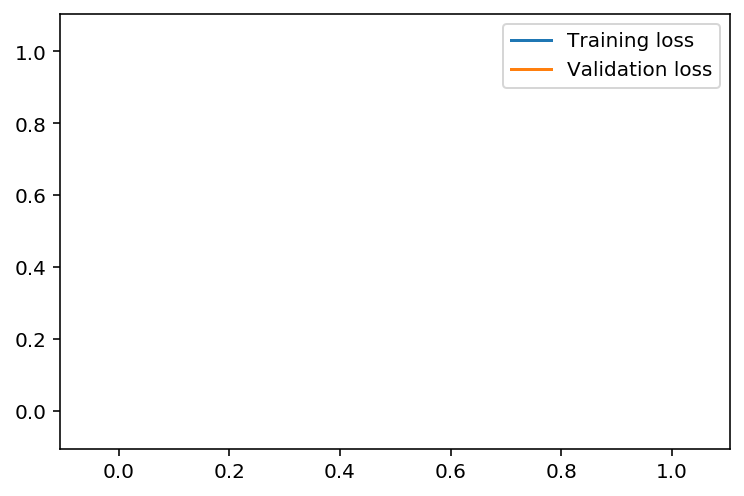

In [46]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

### Check out your predictions
Here, use the test data to view how well your network is modeling the data. If something is completely wrong here, make sure each step in your network is implemented correctly.

NameError: name 'scaled_features' is not defined

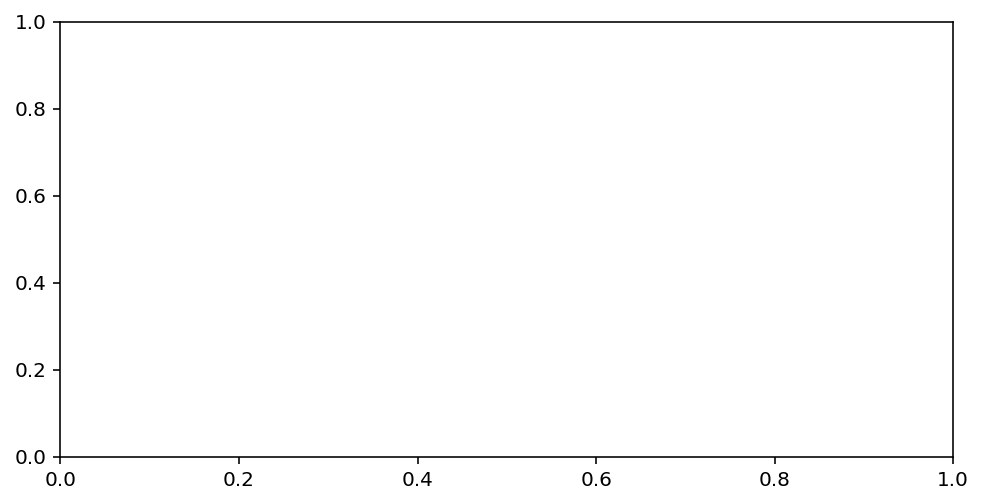

In [47]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']
predictions = network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)